In [14]:
import casadi as ca
import casadi.tools as cat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import networkx as nx
import sys
import seaborn as sns
sys.path.insert(0, './ocp-solving')
from COVIDVaccinationOCP import COVIDVaccinationOCP, rk4_mob, rhs_py_total, rk4, rhs_py_total_mob
from ItalySetup import ItalySetup
from scipy.integrate import solve_ivp
import matlab.engine
eng = matlab.engine.start_matlab()
eng.cd('geography-paper-master/',nargout=0)
eng.run('single_build.m', nargout=0)

parameters = np.array(eng.eval('PAR'))

s = ItalySetup()

ocp_params = {'N': 52,
              'T': 52*7,               # N * 7
              'n_int_steps': 100,
               'scaling':  1e-3
             }


scaling = ocp_params['scaling']
N = ocp_params['N']
T = ocp_params['T']
n_int_steps = ocp_params['n_int_steps']



obj_params = {
        'scale_ell' : 1e0,
        'scale_If'  : 1e2,
        'scale_v'   : 1e-6
        }

ocp = COVIDVaccinationOCP(
    N = ocp_params['N'],
    T = ocp_params['T'],
    n_int_steps = ocp_params['n_int_steps'],
    scaling = ocp_params['scaling'],
    setup = s,
    model_params = model_params,
    obj_params = obj_params,
    optimize=False
    )

pnum = np.array(ocp.arg['p']['p'])


# New code
x0 = np.zeros(4*s.nnodes)
nx = 4
for i in range(s.nnodes): 
    x0[i*nx:(i+1)*nx] = [s.ic['I'][i]*scaling, 
                         s.ic['R'][i]*scaling, 
                         s.ic['B'][i],
                         s.ic['V'][i]*scaling]
dt = T/N/n_int_steps

integ_rk4 =  np.array([x0]).T
integ_rk4_mob =  np.array([x0]).T
integ_nomob = np.array([x0]).T
integ_withmob =  np.array([x0]).T


Loaded Italy Setup with 10 nodes.
Building OCP with 10 nodes


<Figure size 640x480 with 6 Axes>

<Figure size 640x480 with 6 Axes>

<Figure size 640x480 with 1 Axes>

Done building OCP, ready for use.


In [5]:
for k in range(N):
    print(k, end = ':')
    covk = np.squeeze(ca.veccat(*ocp.arg['p']['cov',:,k]))  
    mob = []
    for i in range(s.nnodes):
        mob.append(float( sum( 
            s.mobility[i,j]*integ_withmob[j*4+2,-1]/(1+integ_withmob[j*4+2,-1]) for j in range(s.nnodes) ) ))
    uk = np.zeros(10).T         # no contro3l
    #uk = 15000* scaling * np.ones(10).T        # somehow makes the integration very difficult
    x_ = rk4(      dt, integ_rk4[:,-1],    uk, covk, pnum, s.nnodes, s.mobility ,n_int_steps,      s.pop_node*scaling)
    sol_ = rk4_mob(dt, integ_rk4_mob[:,-1],uk, covk, pnum, s.nnodes, s.mobility, n_int_steps, mob, s.pop_node*scaling)
    sol0 = solve_ivp(lambda t, y: rhs_py_total(t, y, uk, covk, pnum, s.nnodes, s.mobility, s.pop_node*scaling),
                     [0,T/N], integ_nomob[:,-1])#, rtol=1e-8, atol=1e-8)
    sol1 = solve_ivp(lambda t, y: rhs_py_total_mob(t, y, uk, covk, pnum, s.nnodes, s.mobility, mob, s.pop_node*scaling),
                     [0,T/N], integ_withmob[:,-1])#, rtol=1e-8, atol=1e-8)
    
    integ_nomob  =  np.append(integ_nomob,   np.array([sol0['y'][:,-1]]).T, axis=1)
    integ_withmob = np.append(integ_withmob, np.array([sol1['y'][:,-1]]).T, axis=1)
    integ_rk4 =     np.append(integ_rk4,     np.array([x_]).T,              axis=1)
    integ_rk4_mob = np.append(integ_rk4_mob, np.array([sol_]).T,            axis=1)

0:1:2:3:4:5:6:7:8:9:10:11:12:13:14:15:16:17:18:19:20:21:22:23:24:25:26:27:28:29:30:31:32:33:34:35:36:37:38:39:40:41:42:43:44:45:46:47:48:49:50:51:

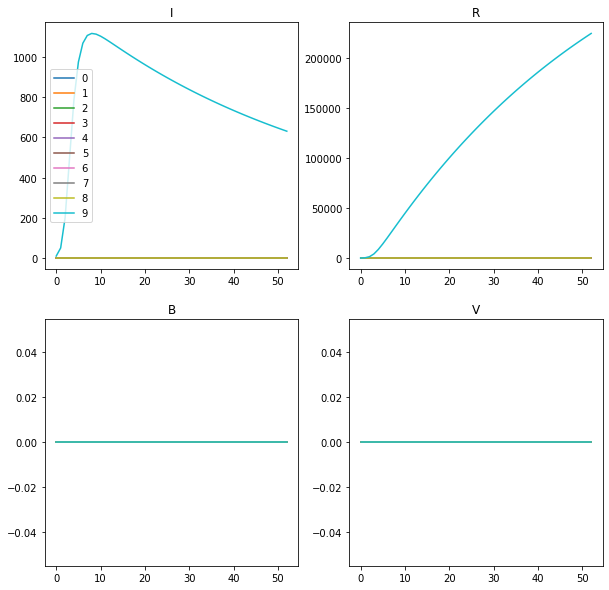

In [6]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
integ_to_plot = integ_rk4

for i in range(s.nnodes):
    axes.flat[0].plot(integ_to_plot[i*4,:].T/scaling)
    axes.flat[1].plot(integ_to_plot[i*4+1,:].T/scaling)
    axes.flat[2].plot(integ_to_plot[i*4+2,:].T)
    axes.flat[3].plot(integ_to_plot[i*4+3,:].T/scaling)

axes.flat[0].legend(np.arange(10));
axes.flat[0].set_title('I');
axes.flat[1].set_title('R');
axes.flat[2].set_title('B');
axes.flat[3].set_title('V');

Text(0.5, 1.0, 'V')

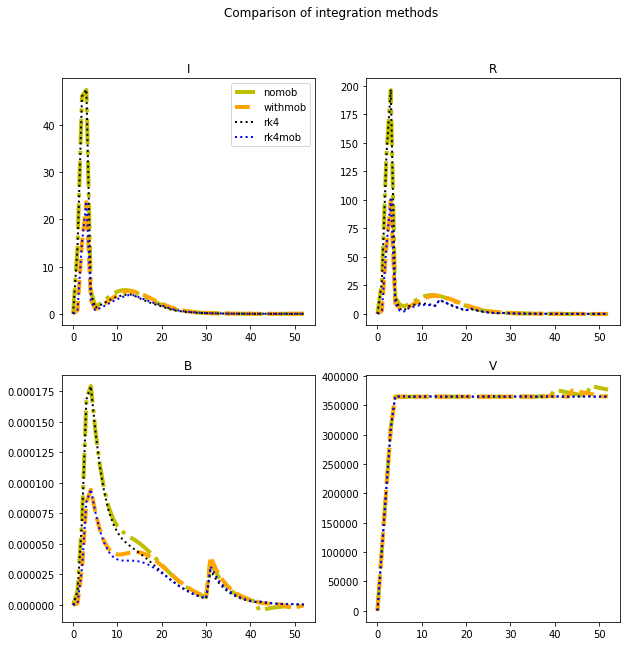

In [4]:
fig, axes = plt.subplots(2,2, figsize = (10,10))

node = 3
til = 53  # 53 for full matrix

axes.flat[0].plot(integ_nomob[node*4,:til].T/scaling, linestyle='-.', lw = 4, color='y')
axes.flat[1].plot(integ_nomob[node*4+1,:til].T/scaling, linestyle='-.', lw = 4, color='y')
axes.flat[2].plot(integ_nomob[node*4+2,:til].T, linestyle='-.', lw = 4, color='y')
axes.flat[3].plot(integ_nomob[node*4+3,:til].T/scaling, linestyle='-.', lw = 4, color='y')

axes.flat[0].plot(integ_withmob[node*4,:til].T/scaling, linestyle='--', lw = 4, color='orange')
axes.flat[1].plot(integ_withmob[node*4+1,:til].T/scaling, linestyle='--', lw = 4, color='orange')
axes.flat[2].plot(integ_withmob[node*4+2,:til].T, linestyle='--', lw = 4, color='orange')
axes.flat[3].plot(integ_withmob[node*4+3,:til].T/scaling, linestyle='--', lw = 4, color='orange')

axes.flat[0].plot(integ_rk4[node*4,:til].T/scaling, linestyle=':', lw = 2, color='k')
axes.flat[1].plot(integ_rk4[node*4+1,:til].T/scaling, linestyle=':', lw = 2, color='k')
axes.flat[2].plot(integ_rk4[node*4+2,:til].T, linestyle=':', lw = 2, color='k')
axes.flat[3].plot(integ_rk4[node*4+3,:til].T/scaling, linestyle=':', lw = 2, color='k')

axes.flat[0].plot(integ_rk4_mob[node*4,:til].T/scaling, linestyle=':', lw = 2, color='b')
axes.flat[1].plot(integ_rk4_mob[node*4+1,:til].T/scaling, linestyle=':', lw = 2, color='b')
axes.flat[2].plot(integ_rk4_mob[node*4+2,:til].T, linestyle=':', lw = 2, color='b')
axes.flat[3].plot(integ_rk4_mob[node*4+3,:til].T/scaling, linestyle=':', lw = 2, color='b')

fig.suptitle("Comparison of integration methods")
axes.flat[0].legend(['nomob', 'withmob', 'rk4', 'rk4mob'])
axes.flat[0].set_title('I')
axes.flat[1].set_title('R')
axes.flat[2].set_title('B')
axes.flat[3].set_title('V')

In [9]:
ca.atan(1e2*100)/np.pi+0.5

0.9999681690114877

In [17]:
for name in ocp.ic.keys():
    for i in range(s.nnodes):
        ocp.arg['lbx']['x',i,0,name] = ocp.arg['ubx']['x',i,0,name] = ocp.ic[name][i] 

ocp.arg['ubx']['u',:,:,'v'] = 15000 * scaling
ocp.arg['p']['p','scale_v'] = 1e-0 / scaling # with scaling = 1
ocp.arg['p']['p','scale_ell'] = 1e0
ocp.arg['p']['p','scale_If'] = 1e0

x0 = []
for i in range(len(s.ind2name)):
    for name in ocp.states.keys():
        x0 += [ocp.ic[name][i]]
x0 = np.squeeze(ca.veccat(*x0))
pnum = np.array(ocp.arg['p']['p'])


init = ocp.Vars(0)
# This init with the highest vaccination
for i in range(len(s.ind2name)):
    k_max = int(s.pop_node[i]*scaling/ocp.arg['ubx']['u',i,-1,'v']/T*N - 1e-8)
    init['u',i,:k_max,'v'] = 0#ocp.arg['ubx']['u',i,:k_max,'v']

sol0 = {}
dt = T/N/n_int_steps
for i in range(len(s.ind2name)):
    for name in ocp.states.keys():
        init['x',i,0,name] = ocp.ic[name][i]
sim = np.array([x0]).T

# Rough integration with fixed mobility? as a strating point
for k in range(N):
    uk = np.squeeze(ca.veccat(*init['u',:,k,'v']))
    covk = np.squeeze(ca.veccat(*ocp.arg['p']['cov',:,k]))
    mob = []
    for i in range(s.nnodes): 
        mob.append(float( sum( s.mobility[i,j]*sim[j*4+2,-1]/(1+sim[j*4+2,-1]) for j in range(s.nnodes) ) ))
    sol_ = rk4_mob(dt,sim[:,-1],uk, covk, pnum, s.nnodes, s.mobility, n_int_steps, mob, s.pop_node*scaling)
    sol0['y'] = np.array([sol_]).T
    sim  = np.append( sim, np.array([sol0['y'][:,-1]]).T, axis=1)
    for i in range(len(s.ind2name)):
        init['x',i,k+1] = np.array([sol0['y'][i*4:(i+1)*4,-1]])

[fnum,gnum] = ocp.nlpFun(init,ocp.arg['p'])
gnum = ocp.g(gnum)

ocp.arg['x0'] = init
# ocp.arg['x0'] = opt

ocp.arg['ubg']['vaccines'] = 3e6 * scaling


# ------------------------------------- SOLVING OCP --------------------------------------
opt = ocp.solveOCP()
# ------------------------------------- SOLVING OCP --------------------------------------

print(ocp.costTerms(opt,ocp.arg['p']))

[fnum,gnum]=ocp.nlpFun(ocp.opt,ocp.arg['p'])
print(ocp.g(gnum)['vaccines'] - ocp.arg['ubg']['vaccines'])

This is Ipopt version 3.12.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    19510
Number of nonzeros in inequality constraint Jacobian.:      520
Number of nonzeros in Lagrangian Hessian.............:    11050

Reallocating memory for MA57: lfact (373619)
Reallocating memory for MA57: lfact (398686)
Total number of variables............................:     3120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      520
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2600
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

SystemError: <built-in function Function_call> returned a result with an error set

In [ ]:
ocp.arg['p']['p','scale_v'] = 1e-0 / scaling # with scaling = 1
ocp.arg['p']['p','scale_ell'] = 1e2
ocp.arg['p']['p','scale_If'] = 1e2

ocp.arg['x0'] = opt


# ------------------------------------- SOLVING OCP --------------------------------------
opt = ocp.solveOCP()
# ------------------------------------- SOLVING OCP --------------------------------------

print(ocp.costTerms(opt,ocp.arg['p']))

[fnum,gnum]=ocp.nlpFun(ocp.opt,ocp.arg['p'])
print(ocp.g(gnum)['vaccines'] - ocp.arg['ubg']['vaccines'])

Text(0.5, 1.0, 'V')

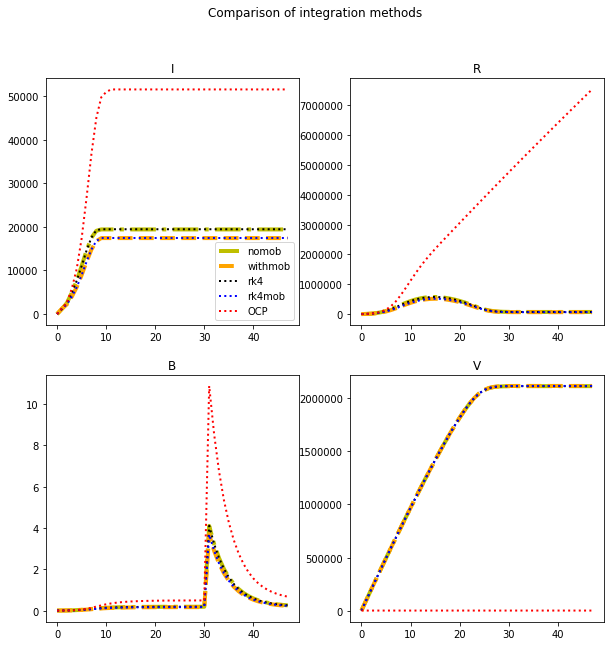

In [5]:
fig, axes = plt.subplots(2,2, figsize = (10,10))

node = 0
til = -5  # 53 for full matrix

axes.flat[0].plot(integ_nomob[node*4,:til].T/scaling, linestyle='-.', lw = 4, color='y')
axes.flat[1].plot(integ_nomob[node*4+1,:til].T/scaling, linestyle='-.', lw = 4, color='y')
axes.flat[2].plot(integ_nomob[node*4+2,:til].T, linestyle='-.', lw = 4, color='y')
axes.flat[3].plot(integ_nomob[node*4+3,:til].T/scaling, linestyle='-.', lw = 4, color='y')

axes.flat[0].plot(integ_withmob[node*4,:til].T/scaling, linestyle='--', lw = 4, color='orange')
axes.flat[1].plot(integ_withmob[node*4+1,:til].T/scaling, linestyle='--', lw = 4, color='orange')
axes.flat[2].plot(integ_withmob[node*4+2,:til].T, linestyle='--', lw = 4, color='orange')
axes.flat[3].plot(integ_withmob[node*4+3,:til].T/scaling, linestyle='--', lw = 4, color='orange')

axes.flat[0].plot(integ_rk4[node*4,:til].T/scaling, linestyle=':', lw = 2, color='k')
axes.flat[1].plot(integ_rk4[node*4+1,:til].T/scaling, linestyle=':', lw = 2, color='k')
axes.flat[2].plot(integ_rk4[node*4+2,:til].T, linestyle=':', lw = 2, color='k')
axes.flat[3].plot(integ_rk4[node*4+3,:til].T/scaling, linestyle=':', lw = 2, color='k')

axes.flat[0].plot(integ_rk4_mob[node*4,:til].T/scaling, linestyle=':', lw = 2, color='b')
axes.flat[1].plot(integ_rk4_mob[node*4+1,:til].T/scaling, linestyle=':', lw = 2, color='b')
axes.flat[2].plot(integ_rk4_mob[node*4+2,:til].T, linestyle=':', lw = 2, color='b')
axes.flat[3].plot(integ_rk4_mob[node*4+3,:til].T/scaling, linestyle=':', lw = 2, color='b')

axes.flat[0].plot(np.array(ca.veccat(*opt['x',node,:til,'I']))/scaling, 
                  linestyle=':', lw = 2, color='r')
axes.flat[1].plot(np.array(ca.veccat(*opt['x',node,:til,'R']))/scaling,
                  linestyle=':', lw = 2, color='r')
axes.flat[2].plot(np.array(ca.veccat(*opt['x',node,:til,'B'])),
                  linestyle=':', lw = 2, color='r')
axes.flat[3].plot(np.array(ca.veccat(*opt['x',node,:til,'V']))/scaling, 
                  linestyle=':', lw = 2, color='r')


fig.suptitle("Comparison of integration methods")
axes.flat[0].legend(['nomob', 'withmob', 'rk4', 'rk4mob', 'OCP'])
axes.flat[0].set_title('I')
axes.flat[1].set_title('R')
axes.flat[2].set_title('B')
axes.flat[3].set_title('V')

In [3]:
x0/scaling

array([  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   , 319.261,   0.   , 500.   ,   0.   ])

In [7]:
s.pop_node*0.1

array([214325.4, 118703.9,  57875.1,  36575. ,  49810.2,  47990.2,
        29993. ,  66115.6,  30712.6,  31926.1])

In [12]:
s = KenyaSetup()

Created setup with 10 nodes.


In [13]:
s.ic

{'I': array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 319261.]),
 'R': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'B': array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5]),
 'V': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [14]:
x0 = np.zeros(4*s.nnodes)
nx = 4
for i in range(s.nnodes): 
    x0[i*nx:(i+1)*nx] = [s.ic['I'][i]*scaling, 
                         s.ic['R'][i]*scaling, 
                         s.ic['B'][i],
                         s.ic['V'][i]*scaling]

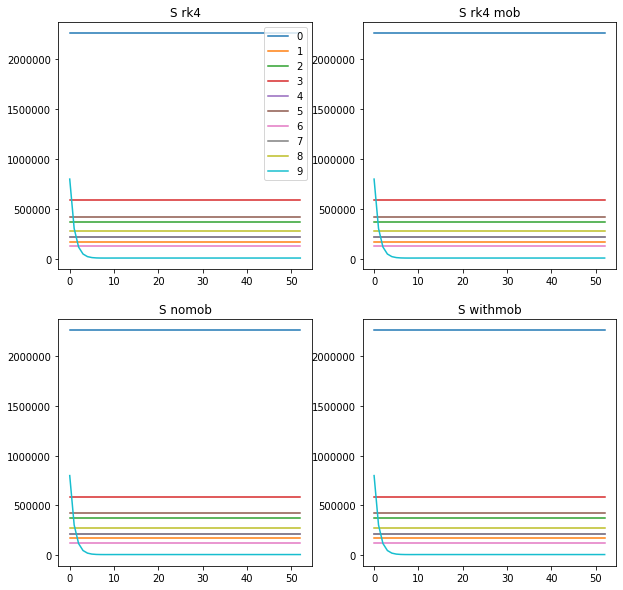

In [5]:
fig, axes = plt.subplots(2,2, figsize = (10,10))

for i in range(s.nnodes):
    axes.flat[0].plot(s.pop_node[i] - integ_rk4[i*4,:].T/scaling - integ_rk4[i*4+1,:].T/scaling - integ_rk4[i*4+3,:].T/scaling)
    axes.flat[1].plot(s.pop_node[i] - integ_rk4_mob[i*4,:].T/scaling - integ_rk4_mob[i*4+1,:].T/scaling - integ_rk4_mob[i*4+3,:].T/scaling)
    axes.flat[2].plot(s.pop_node[i] - integ_nomob[i*4,:].T/scaling - integ_nomob[i*4+1,:].T/scaling - integ_nomob[i*4+3,:].T/scaling)
    axes.flat[3].plot(s.pop_node[i] - integ_withmob[i*4,:].T/scaling - integ_withmob[i*4+1,:].T/scaling - integ_withmob[i*4+3,:].T/scaling)




axes.flat[0].legend(np.arange(10));
axes.flat[0].set_title('S rk4');
axes.flat[1].set_title('S rk4 mob');
axes.flat[2].set_title('S nomob');
axes.flat[3].set_title('S withmob');

In [5]:
integ_to_plot[i*4+2,:]

array([5.00000000e-01, 4.18334000e-01, 3.39175921e-01, 2.67828116e-01,
       2.08371008e-01, 1.61822483e-01, 1.25640511e-01, 9.75563103e-02,
       7.57543985e-02, 5.88225230e-02, 4.56733756e-02, 3.54634181e-02,
       2.75378248e-02, 2.13836280e-02, 1.66030079e-02, 1.28917184e-02,
       1.00097570e-02, 7.77164896e-03, 6.03432680e-03, 4.68548906e-03,
       3.63786993e-03, 2.82455565e-03, 2.19318365e-03, 1.70289453e-03,
       1.32213852e-03, 1.02657894e-03, 7.97108797e-04, 6.18884993e-04,
       4.80521174e-04, 3.73109483e-04, 2.89700165e-04, 2.24924885e-04,
       1.74643610e-04, 1.35605889e-04, 1.05285965e-04, 8.17471880e-05,
       6.34741049e-05, 4.92843349e-05, 3.82646503e-05, 2.97106904e-05,
       2.30694897e-05, 1.79114037e-05, 1.39069607e-05, 1.07983263e-05,
       8.38433573e-06, 6.50965100e-06, 5.05443609e-06, 4.05808511e-06,
       3.15074596e-06, 2.47249623e-06, 1.91981307e-06, 1.49063347e-06,
       1.15733674e-06])

In [6]:
0.2*4.80521174e-04/(1+4.80521174e-04)

9.605807686013499e-05